In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.2882],
         [-0.0417]]),
 tensor([[ 1.0000e+00,  2.8822e-01,  4.1537e-02,  3.9906e-03,  2.8755e-04,
           1.6576e-05,  7.9626e-07,  3.2786e-08,  1.1812e-09,  3.7828e-11,
           1.0903e-12,  2.8568e-14,  6.8618e-16,  1.5213e-17,  3.1320e-19,
           6.0182e-21,  1.0841e-22,  1.8381e-24,  2.9432e-26,  4.4648e-28],
         [ 1.0000e+00, -4.1745e-02,  8.7134e-04, -1.2125e-05,  1.2654e-07,
          -1.0565e-09,  7.3505e-12, -4.3836e-14,  2.2874e-16, -1.0610e-18,
           4.4292e-21, -1.6809e-23,  5.8475e-26, -1.8777e-28,  5.5990e-31,
          -1.5582e-33,  4.0655e-36, -9.9834e-39,  2.3154e-41, -5.0447e-44]]),
 tensor([5.2856, 5.0680]))

# 对模型进行训练和测试

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

# 三阶多项式函数拟合(正态)

weight: [[ 5.0006237  1.1709306 -3.3914359  5.6301565]]


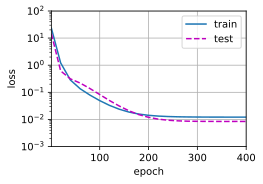

In [6]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

# 线性函数拟合(欠拟合)

weight: [[3.508618  3.8403125]]


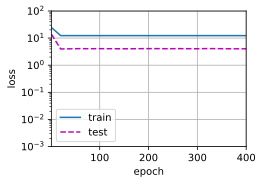

In [7]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

# 高阶多项式函数拟合(过拟合)

weight: [[ 4.9954581e+00  1.2319622e+00 -3.3749657e+00  5.3062224e+00
   2.2334510e-02  8.8331407e-01  1.6829117e-01 -1.1417750e-01
   2.3676834e-01  4.5190886e-02 -7.0237793e-02 -5.2261006e-02
   2.0373186e-01 -1.9739942e-01 -1.8117711e-02 -1.1757087e-01
  -4.0269820e-03 -1.2171152e-01 -1.8835708e-01 -2.0773949e-01]]


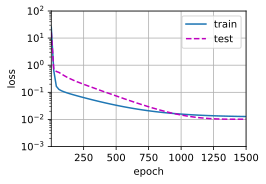

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)